In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

from desc import set_device
set_device("gpu")


import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

import desc
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import *
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import *
from desc.profiles import *

from desc.backend import jnp
from desc.compute import get_params, get_profiles, get_transforms
from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives.normalization import compute_scaling_factors
from desc.coils import MixedCoilSet
from desc.magnetic_fields import *
from desc.magnetic_fields._core import B_from_surface_integral
import time

/home/yigit/Codes/DESC/desc/__init__.py:98: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


DESC version 0.12.1+7.g2ea24b4f1,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 8.65 GB available memory


In [9]:
# coils = MixedCoilSet.from_makegrid_coilfile("Giuliani.is.free.0403.3.00050.coils")
eq = get("ARIES-CS")    
# rpz = jnp.array([0.5, 0.5, 0.5])     # A single point in space
# grid = Grid(rpz, NFP=eq.NFP)     # to use eq.compute we need a grid object
# field = eq.compute("B", grid=grid)["B"]     # set override_grid to False to use function inside jit

# rho=0.52
# Bfield = FourierCurrentPotentialField.from_surface(
#             eq.get_surface_at(rho=rho)
#         )
# print(field)
# Bfield.compute_magnetic_field(rpz)

eq.current.params

array([ 0.00000000e+00, -1.02465744e+05, -8.98981119e+06,  4.48257183e+07,
       -2.32999738e+08,  8.06848481e+08, -1.83850603e+09,  2.67200864e+09,
       -2.39054814e+09,  1.20737821e+09, -2.63366392e+08,  0.00000000e+00,
        0.00000000e+00])

In [28]:
eq = get("ARIES-CS")    
res = 50
grid_source = LinearGrid(rho=1, M=res, N=res, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "|e_theta x e_zeta|",
    "R",
    "phi",
    "Z",
    "e^rho",
    "e^theta",
]
data_source = eq.compute(keys, grid=grid_source)

R = np.linspace(min(data_source["R"]), max(data_source["R"]), 120) # 140
Z = np.linspace(min(data_source["Z"]), max(data_source["Z"]), 120) # 140
phi = np.linspace(0, 2 * np.pi / 2, 120) # 120

rs = jnp.vstack((data_source["R"], data_source["phi"], data_source["Z"])).T
dA = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
K = data_source["K_vc"]

def custom_b(coords, params=None, basis="rpz", source_grid=None, transforms=None):
    return B_from_surface_integral(coords, rs, K, NFP=eq.NFP, dA=dA)

Bfield = ToroidalMagneticField(1,1)
Bfield.compute_magnetic_field = custom_b


In [29]:
nturns = 5  # how many turns
nplanes = 2  # how many places within 1 field period do we want output

rho=0.52
# for starting locations we'll pick positions on flux surfaces on the outboard midplane
grid = LinearGrid(rho=rho, theta=0)

r0 = eq.compute("R", grid=grid)["R"]
z0 = eq.compute("Z", grid=grid)["Z"]
phis = (
    np.linspace(0, 2 * np.pi / eq.NFP, nplanes, endpoint=False)
    + np.arange(0, nturns)[:, None] * 2 * np.pi / eq.NFP
).flatten()

print(f"{r0.shape=}, {z0.shape=}, {phis.shape=}")

r0.shape=(1,), z0.shape=(1,), phis.shape=(10,)


In [30]:
import time
t0=time.time()

rs, zs = field_line_integrate(r0, z0, phis, Bfield)
print(f"took {time.time()-t0} seconds")

zs = zs.reshape((nturns, nplanes, -1))
rs = rs.reshape((nturns, nplanes, -1))

took 2883.3641481399536 seconds


/home/ye2698/DESC/desc/utils.py:495: FutureWarning: argument zeta has been renamed to phi, zeta will be removed in a future release
  warnings.warn(


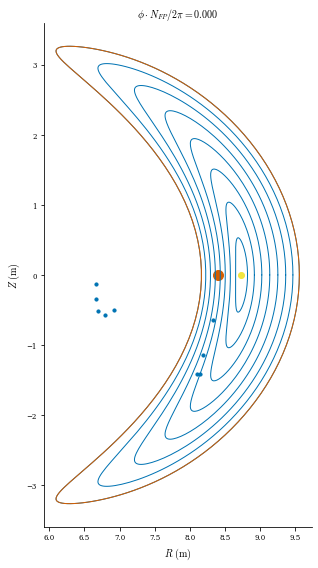

In [27]:
fig,ax=plot_surfaces(eq,theta=0,zeta=np.array(0.0),figsize=(8,8))
ax[0].scatter(rs,zs,s=10)
ax[0].scatter(r0,z0,s=100)

In [ ]:
fig, ax = plot_surfaces(eq,figsize=(20,20))
ax = ax.flatten()
# for i in range(nplanes):
i=0
ax[i].scatter(rs[:, i, :], zs[:, i, :], s=5)
for i,j in zip([5,4,3,2,1],[1,2,3,4,5]):
    ax[i].scatter(rs[:, j, :], zs[:, j, :], s=5)